# Run wind farm simulation

In [12]:
# import and setup site and windTurbines
import numpy as np
import matplotlib.pyplot as plt
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake import IEA37SimpleBastankhahGaussian

site = IEA37Site(16)
x, y = site.initial_position.T
windTurbines = IEA37_WindTurbines()

wf_model = IEA37SimpleBastankhahGaussian(site, windTurbines)

print(wf_model)

IEA37SimpleBastankhahGaussian(PropagateDownwind, IEA37SimpleBastankhahGaussianDeficit-wake, SquaredSum-superposition)


Run the wind farm simulation by calling the wind farm model. The this call will return a `SimulationResult`

In [13]:
# run wind farm simulation
sim_res = wf_model(x, y, # wind turbine positions
                   h=None, # wind turbine heights (defaults to the heights defined in windTurbines)
                   type=0, # Wind turbine types
                   wd=None, # Wind direction (defaults to site.default_wd (0,1,...,360 if not overriden))
                   ws=None, # Wind speed (defaults to site.default_ws (3,4,...,25m/s if not overriden))
                   yaw_ilk=None # yaw misalignment [deg] for all wind turbines(i), wind directions(l) and wind speeds(k)
                  )

## SimulationResult



`SimulationResult` objects contains information about the simulation and the results in terms of:

- simulation input
  - `x_i`, `y_i`, `h_i`, `type_i` (x,y position, hub height and type of all wind turbines)
  - `yaw_ilk` (yaw misalignment [deg] for all wind turbines(i), wind directions(l) and wind speeds(k))
  - `ws` (wind speeds)
  - `wd` (wind directions)
- simulation output
  - `WS_eff_ilk` (effetive wind speed)
  - `TI_eff_ilk` (effective turbulence intensity)
  - `power_ilk` (power production)
  - `ct_ilk` (thrust coefficient)
  - `localWind` (local free flow information)
  
  where the suffixes `_ilk` means for all wind turbines (i), wind directions (l) and wind speeds (k).
  
 

In [14]:
print (sim_res.WS_eff_ilk.shape)

(16, 360, 1)


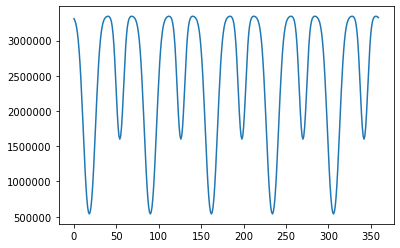

In [15]:
plt.plot(sim_res.wd, sim_res.power_ilk[0,:,0].T)

### AEP calculation

Furthermore, `SimulationResult`, contains a method, `aep` that calculates the Annual Energy Production

In [18]:
sim_res.aep()

373.2066452143561

The `aep` method take an optional input, `with_wake_loss` (default is True), which can be used to e.g. calculate the wake loss of the wind farm

In [19]:
aep_with_wake_loss = sim_res.aep()
aep_witout_wake_loss = sim_res.aep(with_wake_loss=False)
(aep_witout_wake_loss-aep_with_wake_loss) / aep_witout_wake_loss

0.20741308303216552

## Flow map

Finally, `SimulationResult` has a `flow_map` method which returns a `FlowMap` object

In [7]:
flow_map = sim_res.flow_map(grid=None, # defaults to HorizontalGrid(resolution=500, extend=0.2), see below
                            wd=270, 
                            ws=None)

### plot_wake_map

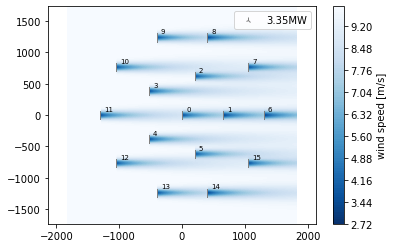

In [8]:
flow_map.plot_wake_map()

(-1820.0, 1820.0, -1730.9229, 1730.9229)

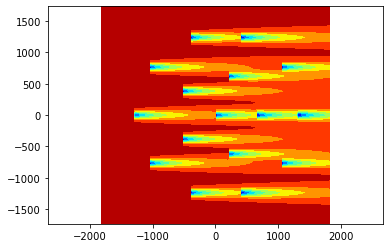

In [9]:
flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
                       cmap='jet', # color map
                       plot_colorbar=False, 
                       plot_windturbines=False, 
                       ax=None)
plt.axis('equal')

#### Grid

The grid argument should be either 

- a `HorizontalGrid` or 
- a tuple(X, Y, x, y, h) where X, Y is the meshgrid for visualizing the data and x, y, h are the flattened grid points

 
##### HorizontalGrid


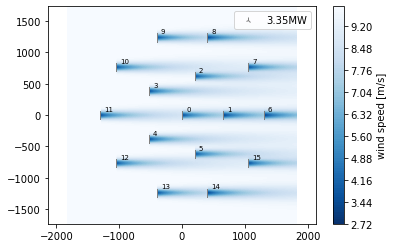

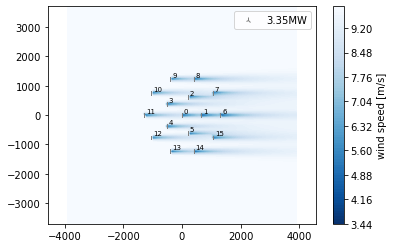

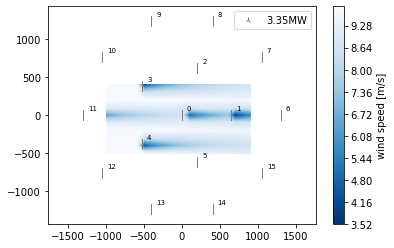

In [10]:
from py_wake import HorizontalGrid
for grid in [None, # defaults to HorizontalGrid(resolution=500, extend=0.2)
             HorizontalGrid(x=None, y=None, resolution=100, extend=1), # custom resolution and extend
             HorizontalGrid(x = np.arange(-1000,1000,100),
                            y = np.arange(-500,500,100)) # custom x and y
            ]:
    plt.figure()
    sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map()

##### Grid tuple(X,Y,x,y,h)

Text(0.5, 0, 'X [m]')

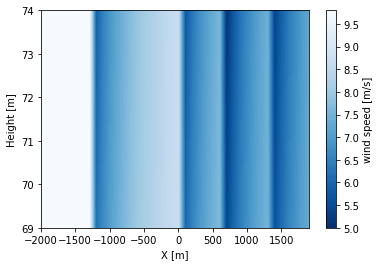

In [11]:
#Vertical grid through y=0

X, H = np.meshgrid(np.arange(-2000,2000,100), np.arange(69,75))
Y = X*0 # y=0
grid = (X,H,X.flatten(), Y.flatten(), H.flatten())

sim_res.flow_map(grid=grid, wd=270, ws=None).plot_wake_map(plot_windturbines=False)
plt.ylabel("Height [m]")
plt.xlabel('X [m]')